# Background

- **Author**: `<林宜萱>`
- **Created At**: `<2025-10-30>`
- **Research Motivation and Context (why are we interested in the findings?)：**
本研究旨在分析遊戲在不同時間點的折扣幅度變化，並探討其與遊戲特徵（如年齡、好評率、是否支援多人模式）及成長變數（如粉絲數變化）之間的關係。透過統計圖表與回歸模型的整合，希望揭示影響折扣率的重要因素，進而理解遊戲市場的價格運作邏輯。
- **Main Findings and Takeaways：**  
    - 折扣幅度整體呈現穩定：分析結果顯示折扣活動在特定時期（例如大型促銷季）集中，折扣幅度於年度中有明顯高峰。

    - 多人遊戲與固定折扣機制具顯著影響：多人遊戲平均折扣率較高。

    - 相關係數熱圖揭示共線性現象：部分變數間存在高相關性（如不同週期的成長率），需於模型中謹慎處理以避免過度解釋。

    綜合來看，遊戲折扣幅度受到多重因素交互影響，特別是市場反應變數，是最主要的解釋來源。
- **Future Direciton：**
    - 納入更多動態變數：如近期遊戲上架數量、評論變化速率、促銷活動期間等，以提升模型對折扣時機的預測力。

    - 建立時間序列預測模型：預測不同遊戲的折扣周期性變化。

    - 比較不同遊戲類型或發行商之間的差異：分析不同遊戲類型或發行商在折扣策略上的差異。

    - 結合機器學習模型進行折扣預測：例如利用 Random Forest 或 XGBoost 模型預測折扣率，以驗證變數重要性並提升實務應用價值。

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from IPython.display import HTML

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  
plt.rcParams['axes.unicode_minus'] = False  


plt.style.use("seaborn-v0_8-whitegrid")
sns.set(font_scale=1.1)


In [4]:
df = pd.read_csv('../data/processed/extent-of-discount-rate-DE.csv')
df.head(10)

,Date,GameID,Type,MultiPlayer,Publisher,ConstantDiscount,Final price,OriginPrice,DiscountRate,DiscountDuration,...,PlayerGrowthRate2W,PlayerGrowthRate1M,FollowersGrowthRate1W,FollowersGrowthRate2W,FollowersGrowthRate1M,PositiveRateGrowthRate1W,PositiveRateGrowthRate2W,PositiveRateGrowthRate1M,DLC_since_last_discount,Sequel_since_last_discount
0,2023-06-29,10,Action,1,Valve,0,18.0,186.0,0.903226,14,...,-0.032626,-0.039192,0.000643,0.001311,0.003055,0.000042,0.000018,0.000018,0,0
1,2023-09-12,10,Action,1,Valve,0,18.0,186.0,0.903226,7,...,0.031983,0.006604,0.000513,0.001057,0.002307,0.000016,0.000035,-0.000034,0,0
2,2023-11-21,10,Action,1,Valve,0,18.0,186.0,0.903226,7,...,-0.030716,0.027451,0.001346,0.001994,0.004094,-0.000154,-0.000151,-0.000155,0,0
3,2023-12-21,10,Action,1,Valve,0,19.0,186.0,0.897849,14,...,-0.032172,-0.014952,0.000824,0.001743,0.004816,0.000014,0.000014,-0.000016,0,0
4,2024-03-14,10,Action,1,Valve,0,18.0,186.0,0.903226,7,...,0.045146,0.009495,0.001006,0.001877,0.003727,0.000014,-0.000004,0.000008,0,0
5,2024-06-27,10,Action,1,Valve,0,18.0,186.0,0.903226,14,...,-0.066440,0.023478,0.000947,0.001418,0.002961,0.000007,0.000021,-0.000042,0,0
6,2024-11-27,10,Action,1,Valve,0,37.0,186.0,0.801075,7,...,0.029186,0.006380,0.001170,0.002328,0.004429,-0.000033,-0.000036,-0.000040,0,0
7,2024-12-19,10,Action,1,Valve,0,37.0,186.0,0.801075,14,...,0.038898,0.067424,0.000939,0.001899,0.005363,-0.000028,-0.000005,0.000050,0,0
8,2025-03-13,10,Action,1,Valve,0,37.0,186.0,0.801075,7,...,-0.083917,-0.083422,0.000927,0.001945,0.004196,0.000012,0.000019,-0.000003,0,0
9,2025-06-26,10,Action,1,Valve,0,37.0,186.0,0.801075,14,...,-0.099633,-0.050041,0.000814,0.001524,0.003406,-0.000009,-0.000026,-0.000081,0,0


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GameID,409.0,497223.716381,297538.620152,10.000000,244850.000000,477160.000000,644930.000000,1.145360e+06
MultiPlayer,409.0,0.503667,0.500599,0.000000,0.000000,1.000000,1.000000,1.000000e+00
ConstantDiscount,409.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
Final price,409.0,220.880196,177.979242,0.000000,119.000000,160.000000,278.000000,9.590000e+02
OriginPrice,409.0,501.114914,326.580574,186.000000,318.000000,398.000000,488.000000,1.599000e+03
DiscountRate,409.0,0.572639,0.193898,0.034301,0.500000,0.600457,0.701005,1.000000e+00
DiscountDuration,409.0,11.222494,5.299545,1.000000,7.000000,11.000000,14.000000,3.200000e+01
DiscountFreq3M,409.0,2.701711,0.898813,1.000000,2.000000,3.000000,3.000000,6.000000e+00
Age,409.0,7.025569,3.988664,2.501370,4.723288,6.027397,7.961644,2.466575e+01
AccumulatedPositiveRate,409.0,0.917436,0.065307,0.738856,0.885042,0.946994,0.967883,9.926429e-01


Definition for each variable:  
    - `Date`: datetime，當次折扣首日。  
    - `GameID`: object，該遊戲 unique 的 ID。  
    - `Type`: object，該遊戲的類型。  
    - `MultiPlayer`: int，該遊戲是否屬多人遊戲。  
    - `Publisher`: object，該遊戲的出版商名稱。  
    - `ConstantDiscount`: int，該遊戲的折扣幅度是否固定。（應為 0）  
    - `DiscountRate`: float，當次折扣的幅度，為正表示降價。（應大於 0，表示降價）  
    - `DiscountDuration`: 當次折扣天數。  
    - `Age`: float，折扣當下距該遊戲發布多少年。  
    - `AccumulatedPositiveRate`: float，該遊戲累計至折扣當下的總評價正面率。  
    - `SalePeriod`: int，當次折扣是否位於季節性促銷期間。  
    - `PlayerGrowthRate1W`: float，玩家數一週的移動平均增長率。  
    - `PlayerGrowthRate2W`:float，玩家數兩週的移動平均增長率。  
    - `PlayerGrowthRate1M`: float，玩家數一個月的移動平均增長率。  
    - `FollowersGrowthRate1W`:float，追蹤人數一週的增長率。  
    - `FollowersGrowthRate2W`:float，追蹤人數兩週的增長率。  
    - `FollowersGrowthRate1M`: float，追蹤人數一個月的增長率。  
    - `PositiveRateGrowthRate1W`:float，評價正面率一週的增長率。  
    - `PositiveRateGrowthRate2W`:float，評價正面率兩週的增長率。  
    - `PositiveRateGrowthRate1M`:float，評價正面率一個月的增長率。  
    - `DLC_since_last_discount`:int，截至上一次折扣結束共推出多少新的 DLC。  
    - `Sequel_since_last_discount`:int，截至上一次折扣結束共堆出多少新的續作。  

### The actual analysis starts below
Make the graphs, summary statistics, regression model below.
Make sure you have followed the guidelines as specified in 
[專案資料夾結構、檔案命名與文件規範](https://docs.google.com/document/d/1sl6gEFMdmiGsiNjLe17UmZ30xKxq15U0Mb2B-Jvusxg/edit?tab=t.33iie8ybx7s4).


In [6]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

### A. 折扣幅度整體與時間趨勢

#### 折扣頻率與折扣幅度關係圖(group by 遊戲)

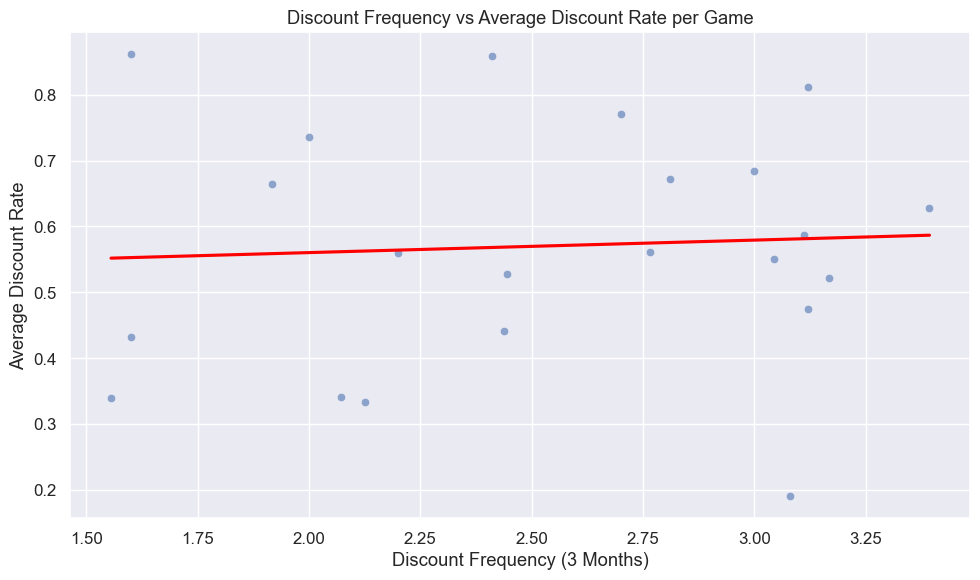

In [8]:
df_freq = df.groupby("GameID")["DiscountRate"].mean().reset_index()
df_freq["DiscountFreq3M"] = df.groupby("GameID")["DiscountFreq3M"].mean().values

plt.figure(figsize=(10, 6))

# Scatter plot
sns.scatterplot(data=df_freq, x="DiscountFreq3M", y="DiscountRate", alpha=0.6)

# Regression line
sns.regplot(
    data=df_freq,
    x="DiscountFreq3M",
    y="DiscountRate",
    scatter=False,     
    color="red",
    ci=None   
)

plt.xlabel('Discount Frequency (3 Months)')
plt.ylabel('Average Discount Rate')
plt.title('Discount Frequency vs Average Discount Rate per Game')

plt.tight_layout()
plt.show()



看起來各個遊戲折扣頻率與折扣幅度之間並沒有明顯相關。

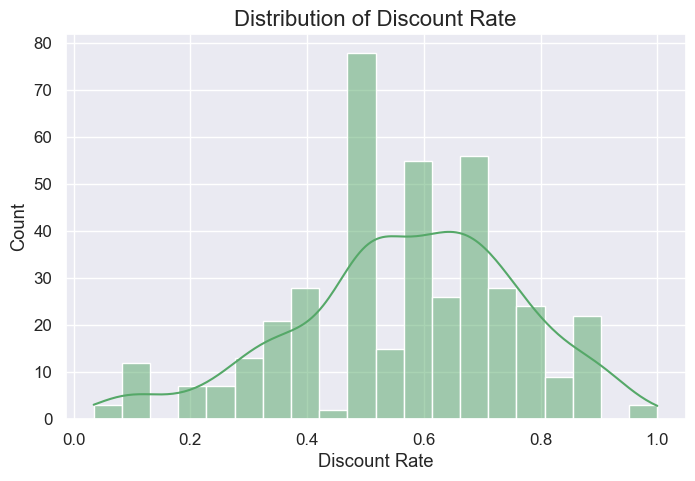

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df["DiscountRate"], bins=20, kde=True, color="#55A868")
plt.title("Distribution of Discount Rate", fontsize=16)
plt.xlabel("Discount Rate")
plt.ylabel("Count")
plt.show()

- 折扣率在 0.5 左右 出現明顯高峰，顯示半價促銷是最常見的折扣策略。
整體分佈並非完全對稱，可能反映部分遊戲在促銷期間傾向提供更高折扣以刺激銷售。

#### 遊戲原價與折扣幅度的關係

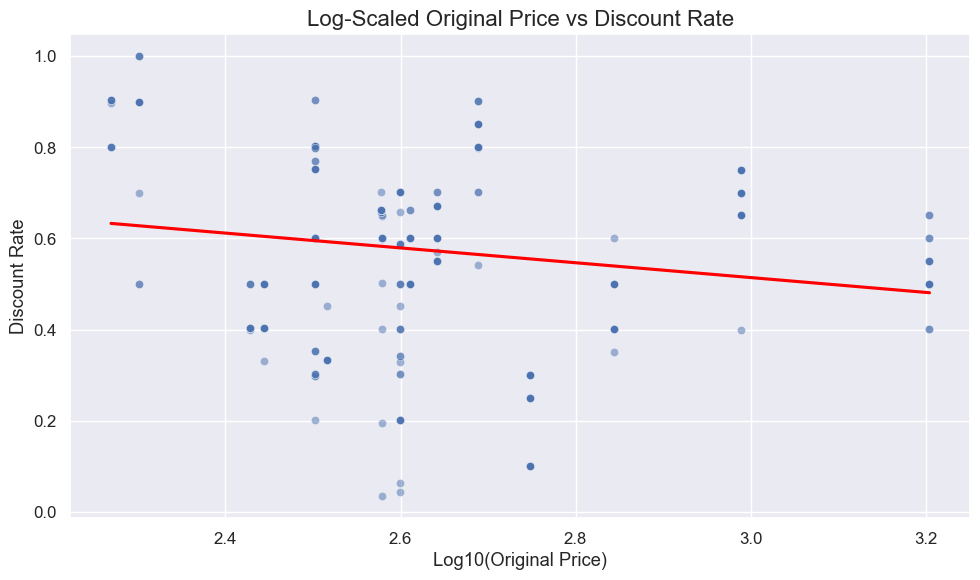

In [17]:
df["LogPrice"] = np.log10(df["OriginPrice"])

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df,
    x="LogPrice",
    y="DiscountRate",
    alpha=0.5,
    color="#4C72B0"
)

sns.regplot(
    data=df,
    x="LogPrice",
    y="DiscountRate",
    scatter=False,
    color="red",
    ci=None
)

plt.title("Log-Scaled Original Price vs Discount Rate", fontsize=16)
plt.xlabel("Log10(Original Price)")
plt.ylabel("Discount Rate")
plt.tight_layout()
plt.show()


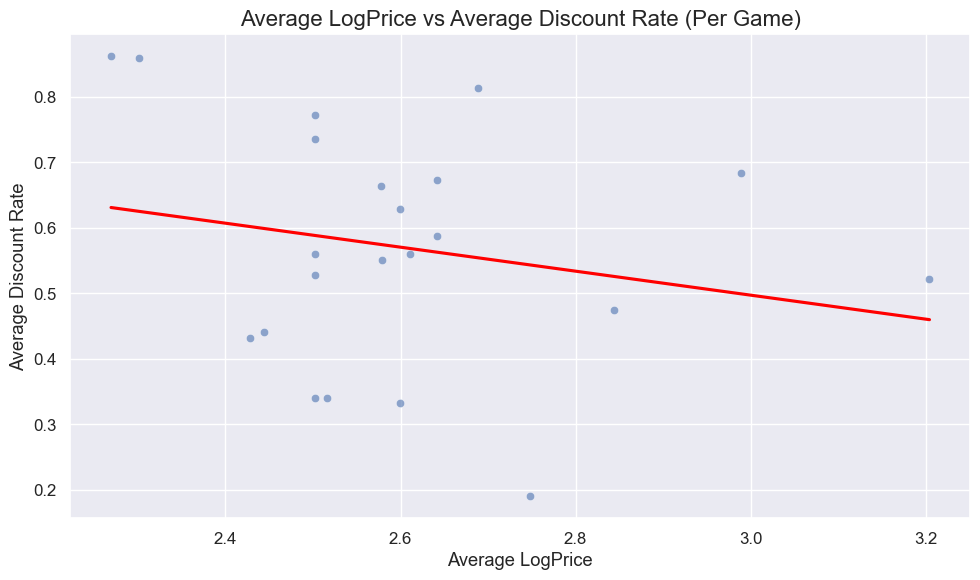

In [18]:
# 以遊戲為單位計算平均原價與平均折扣率
df["LogPrice"] = np.log10(df["OriginPrice"])
df_game = df.groupby("GameID").agg({
    "LogPrice": "mean",
    "DiscountRate": "mean"
}).reset_index()

plt.figure(figsize=(10, 6))

# 散佈圖（每個點是一款遊戲）
sns.scatterplot(
    data=df_game,
    x="LogPrice",
    y="DiscountRate",
    alpha=0.6,
    color="#4C72B0"
)

# 回歸線（不含信賴區間）
sns.regplot(
    data=df_game,
    x="LogPrice",
    y="DiscountRate",
    scatter=False,
    color="red",
    ci=None
)

plt.title("Average LogPrice vs Average Discount Rate (Per Game)", fontsize=16)
plt.xlabel("Average LogPrice")
plt.ylabel("Average Discount Rate")
plt.tight_layout()
plt.show()


用每個遊戲作為分群繪圖，看起來平均折扣率反而跟遊戲原價是負相關。

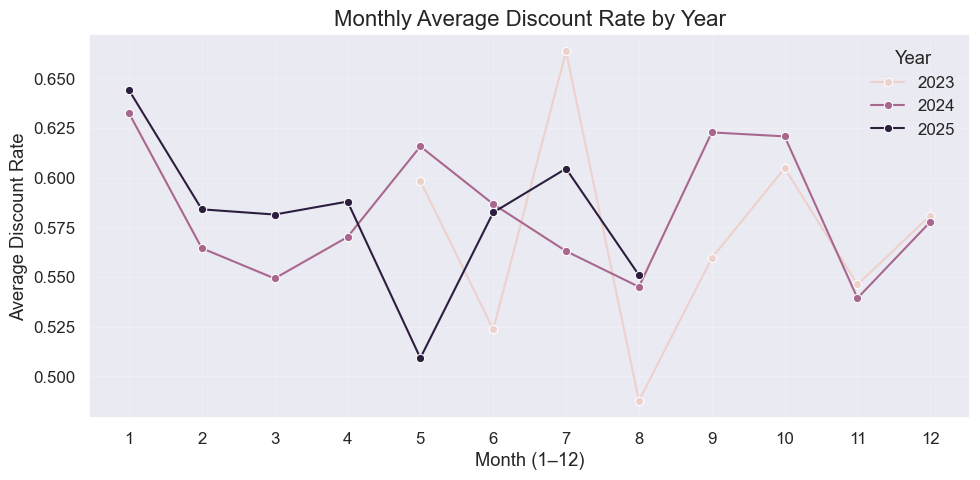

In [ ]:

df["Year"] = df["Date"].dt.year
df["MonthNum"] = df["Date"].dt.month 


trend2 = df.groupby(["Year", "MonthNum"])["DiscountRate"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(
    data=trend2,
    x="MonthNum",
    y="DiscountRate",
    hue="Year",
    marker="o"
)

plt.title("Monthly Average Discount Rate by Year", fontsize=16)
plt.xlabel("Month (1–12)")
plt.ylabel("Average Discount Rate")
plt.xticks(range(1, 13))
plt.legend(title="Year")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()



- 年初（1–3 月）多呈現較高折扣  
- 8 月折扣率明顯下降  
- 年末（9–12 月）多呈現回升走勢  
年初偏高 → 5 月下滑 → 暑期回升 → 8 月回落 → 年末再次上升  
這樣的周期性模式可能反映了遊戲平台常見的促銷週期（如跨年檔、夏季特賣、黑五檔期），對遊戲折扣策略具有一定的定期影響。

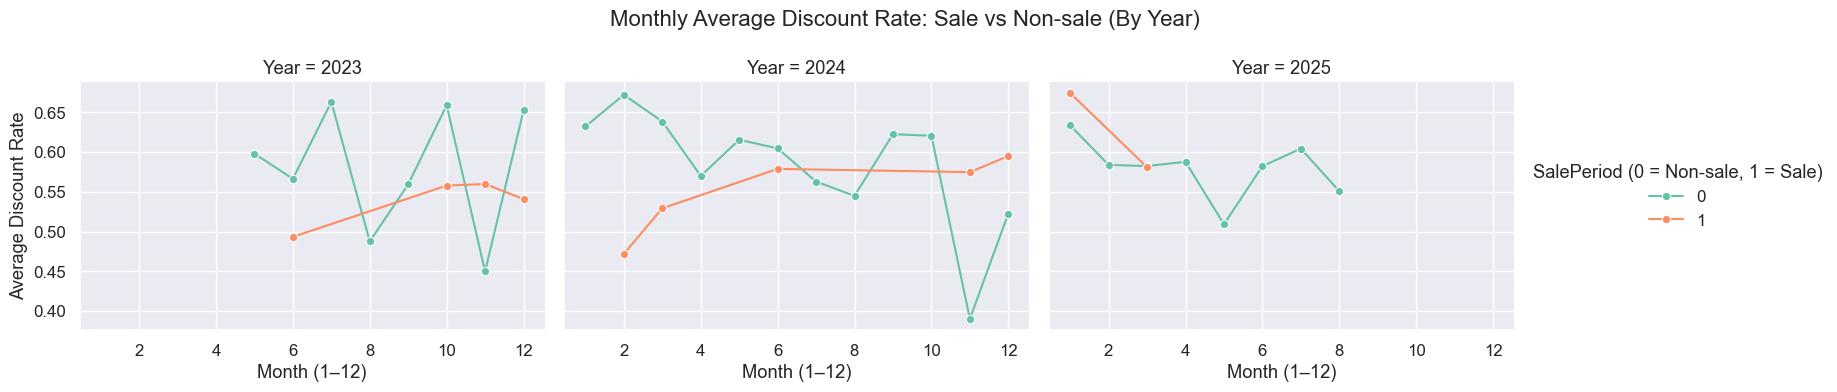

In [13]:
df["Year"] = df["Date"].dt.year
df["MonthNum"] = df["Date"].dt.month 

# 分組計算每年 × 月份 × 是否促銷 的平均折扣
trend_sale = df.groupby(["Year", "MonthNum", "SalePeriod"])["DiscountRate"].mean().reset_index()

# 繪圖：分三年比較 Sale vs Non-sale
g = sns.FacetGrid(trend_sale, col="Year", hue="SalePeriod", height=4, aspect=1.3, palette="Set2", sharey=True)
g.map(sns.lineplot, "MonthNum", "DiscountRate", marker="o")

g.add_legend(title="SalePeriod (0 = Non-sale, 1 = Sale)")
g.set_axis_labels("Month (1–12)", "Average Discount Rate")
plt.subplots_adjust(top=0.8)
g.fig.suptitle("Monthly Average Discount Rate: Sale vs Non-sale (By Year)", fontsize=16)

plt.show()


如果只看2023和2024年的話(資料比較完整的兩年)，可以發現非季節性折扣的幅度變化較大。

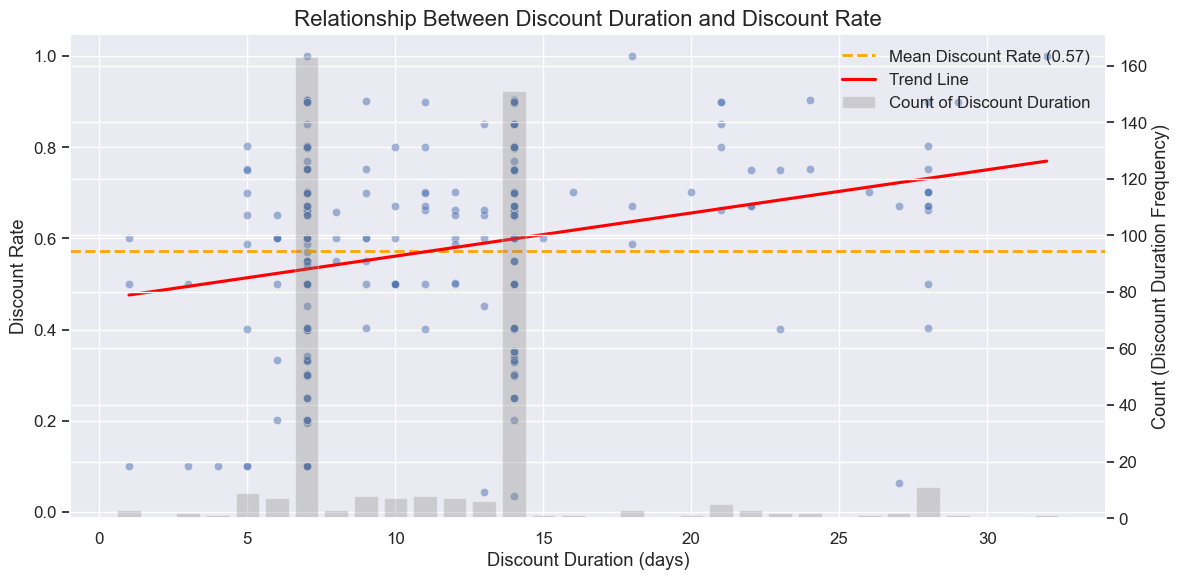

In [ ]:
plt.figure(figsize=(12, 6))

ax1 = plt.gca()

# 散佈圖
sns.scatterplot(
    data=df,
    x="DiscountDuration",
    y="DiscountRate",
    alpha=0.5,
    color="#4C72B0",
    ax=ax1
)

# 平均折扣率線
mean_rate = df["DiscountRate"].mean()
ax1.axhline(mean_rate, color="orange", linestyle="--", linewidth=2, label=f"Mean Discount Rate ({mean_rate:.2f})")

# 趨勢線
sns.regplot(
    data=df,
    x="DiscountDuration",
    y="DiscountRate",
    scatter=False,
    ci=None,
    color="red",
    ax=ax1,
    label="Trend Line"
)

ax1.set_xlabel("Discount Duration (days)")
ax1.set_ylabel("Discount Rate")
ax1.set_title("Relationship Between Discount Duration and Discount Rate", fontsize=16)

# 副軸：折扣天數分佈長條圖 
ax2 = ax1.twinx()

# 統計不同折扣天數的數量
duration_counts = df["DiscountDuration"].value_counts().sort_index()

ax2.bar(
    duration_counts.index,
    duration_counts.values,
    alpha=0.3,
    color="gray",
    label="Count of Discount Duration"
)

ax2.set_ylabel("Count (Discount Duration Frequency)")

# 合併圖例 
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.tight_layout()
plt.show()


- 折扣天數越長，折扣幅度越大（呈正向關係）:  
  若促銷時間拉長，遊戲商較可能提供更高的折扣率來提升曝光或促進銷售，但我們沒有足夠的資訊與證據來解釋這個現象。
- 橘色線代表整體平均折扣幅度，大約落在 0.57 左右。
- 折扣最常出現的天數落在 7 天與 14 天:  
  7 天 ≈ 每週促銷常見週期
  14 天 ≈ 雙週促銷或小型季節促銷

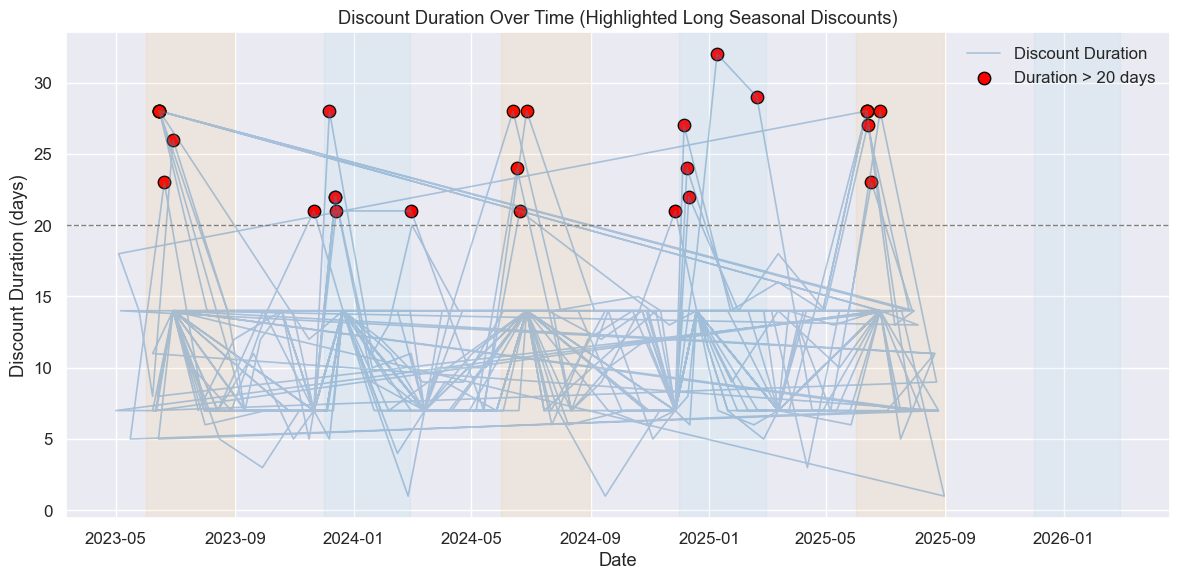

In [59]:
plt.figure(figsize=(12,6))

# 主折線（淡色）
plt.plot(
    df["Date"], df["DiscountDuration"],
    color="steelblue", alpha=0.4, linewidth=1.2,
    label="Discount Duration"
)

# >20 的點（醒目紅點）
df_long = df[df["DiscountDuration"] > 20]
plt.scatter(
    df_long["Date"], df_long["DiscountDuration"],
    color="red", s=80, edgecolors="black",
    label="Duration > 20 days"
)

# 門檻線
plt.axhline(20, color="grey", linestyle="--", linewidth=1)

# 夏季與冬季 shading 
for year in df["Date"].dt.year.unique():
    
    # 夏季：6 ~ 8 月
    plt.axvspan(f"{year}-06-01", f"{year}-08-31",
                color="orange", alpha=0.08)
    
    # 冬季：12~2 月（橫跨兩年）
    plt.axvspan(f"{year}-12-01", f"{year+1}-02-28",
                color="skyblue", alpha=0.10)

plt.title("Discount Duration Over Time (Highlighted Long Seasonal Discounts)")
plt.xlabel("Date")
plt.ylabel("Discount Duration (days)")
plt.legend()
plt.tight_layout()
plt.show()


### B. 遊戲特徵與折扣關係

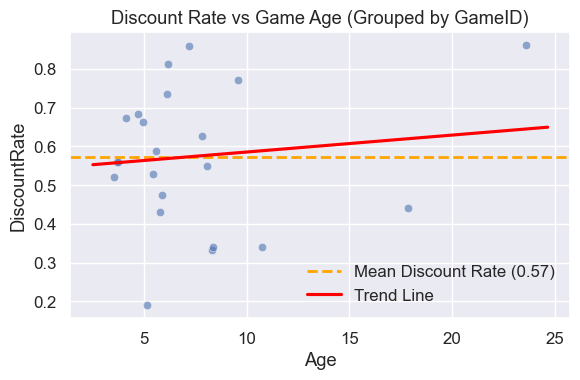

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))

df_game = df.groupby("GameID").agg({
    "Age": "mean",
    "DiscountRate": "mean",
}).reset_index()


# 散佈點
sns.scatterplot(
    data=df_game,
    x="Age",
    y="DiscountRate",
    alpha=0.6,
    ax=ax
)

# 平均折扣率線
mean_rate = df["DiscountRate"].mean()
ax.axhline(mean_rate, color="orange", linestyle="--", linewidth=2,
           label=f"Mean Discount Rate ({mean_rate:.2f})")

# 趨勢線
sns.regplot(
    data=df,
    x="Age",
    y="DiscountRate",
    scatter=False,   
    ci=None,
    color="red",
    ax=ax,
    label="Trend Line"
)

ax.set_title("Discount Rate vs Game Age (Grouped by GameID)")
ax.legend()
plt.tight_layout()
plt.show()




- 較年輕的遊戲(5~10年)，折扣率分布較廣，推測遊戲廠商可能還在測試適合的折扣幅度，反之較年長的遊戲，折扣幅度趨向穩定。  

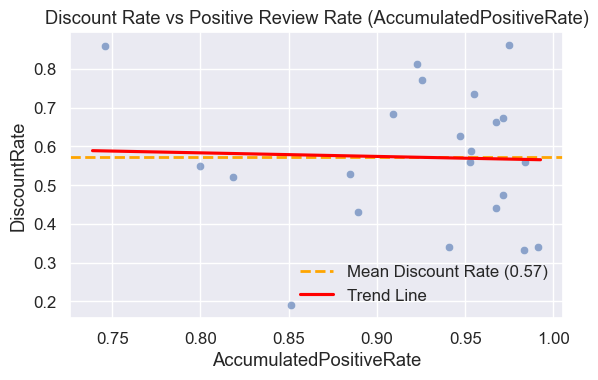

In [31]:
fig, ax = plt.subplots(figsize=(6, 4))

df_game = df.groupby("GameID").agg({
    "AccumulatedPositiveRate": "mean",
    "DiscountRate": "mean"
}).reset_index()

sns.scatterplot(
    data=df_game ,
    x="AccumulatedPositiveRate",
    y="DiscountRate",
    alpha=0.6,
    ax=ax
)

mean_rate = df["DiscountRate"].mean()
ax.axhline(mean_rate, color="orange", linestyle="--", linewidth=2,
           label=f"Mean Discount Rate ({mean_rate:.2f})")

sns.regplot(
    data=df,
    x="AccumulatedPositiveRate",
    y="DiscountRate",
    scatter=False,
    ci=None,
    color="red",
    ax=ax,
    label="Trend Line"
)

ax.set_title("Discount Rate vs Positive Review Rate (AccumulatedPositiveRate)")
ax.legend()
plt.tight_layout()
plt.show()



整體的遊戲評價似乎對折扣幅度沒有巨大關聯。

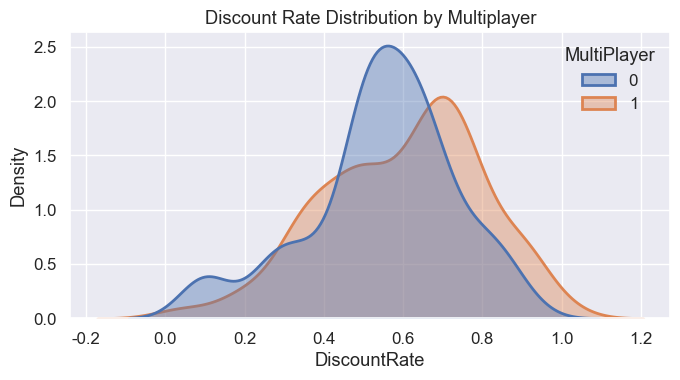

In [49]:
plt.figure(figsize=(7, 4))

sns.kdeplot(
    data=df, x="DiscountRate", hue="MultiPlayer",
    common_norm=False, fill=True, alpha=0.4, linewidth=2
)

plt.title("Discount Rate Distribution by Multiplayer")
plt.xlabel("DiscountRate")
plt.tight_layout()
plt.show()



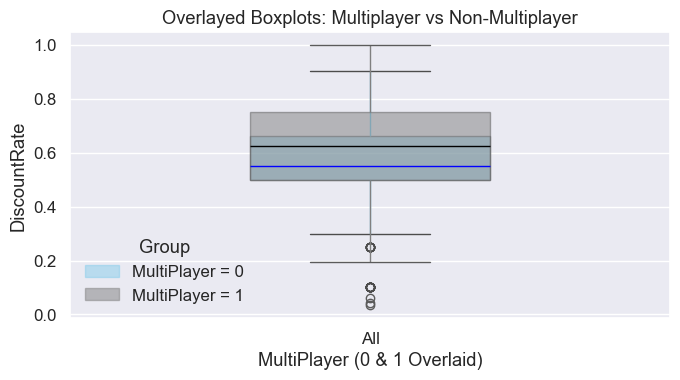

In [ ]:
import matplotlib.patches as mpatches

plt.figure(figsize=(7, 4))

# MultiPlayer = 0 的 box
sns.boxplot(
    data=df[df["MultiPlayer"] == 0],
    x=["All"] * len(df[df["MultiPlayer"] == 0]),
    y="DiscountRate",
    width=0.4,
    boxprops={"facecolor": "skyblue", "alpha": 0.5},
    whiskerprops={"color": "skyblue"},
    medianprops={"color": "blue"},
)

# MultiPlayer = 1 的 box
sns.boxplot(
    data=df[df["MultiPlayer"] == 1],
    x=["All"] * len(df[df["MultiPlayer"] == 1]),
    y="DiscountRate",
    width=0.4,
    boxprops={"facecolor": "grey", "alpha": 0.5},
    whiskerprops={"color": "grey"},
    medianprops={"color": "black"},
)

plt.title("Overlayed Boxplots: Multiplayer vs Non-Multiplayer")
plt.xlabel("MultiPlayer (0 & 1 Overlaid)")
plt.ylabel("DiscountRate")

# 手動建立 legend 
legend_handles = [
    mpatches.Patch(facecolor='skyblue', edgecolor='skyblue', alpha=0.5, label='MultiPlayer = 0'),
    mpatches.Patch(facecolor='grey',    edgecolor='grey',    alpha=0.5, label='MultiPlayer = 1')
]

plt.legend(handles=legend_handles, title="Group")


plt.tight_layout()
plt.show()


- 多人遊戲略有更高折扣幅度傾向，可能反映社交性產品的行銷策略。

### C. 動態變數與折扣關係

圖例：
- 對角線上的圖（Diagonal）：各變數的分布圖（KDE density plot）
- 對角線下方的散點圖（Scatter plot）：兩兩變數間的關係

變數：
- DiscountRate：折扣幅度
- PlayerGrowthRate1W / 2W / 1M：玩家數量在 1 週、2 週、1 個月內的成長率
- FollowersGrowthRate1W / 2W / 1M：Followers 在不同期間的成長率

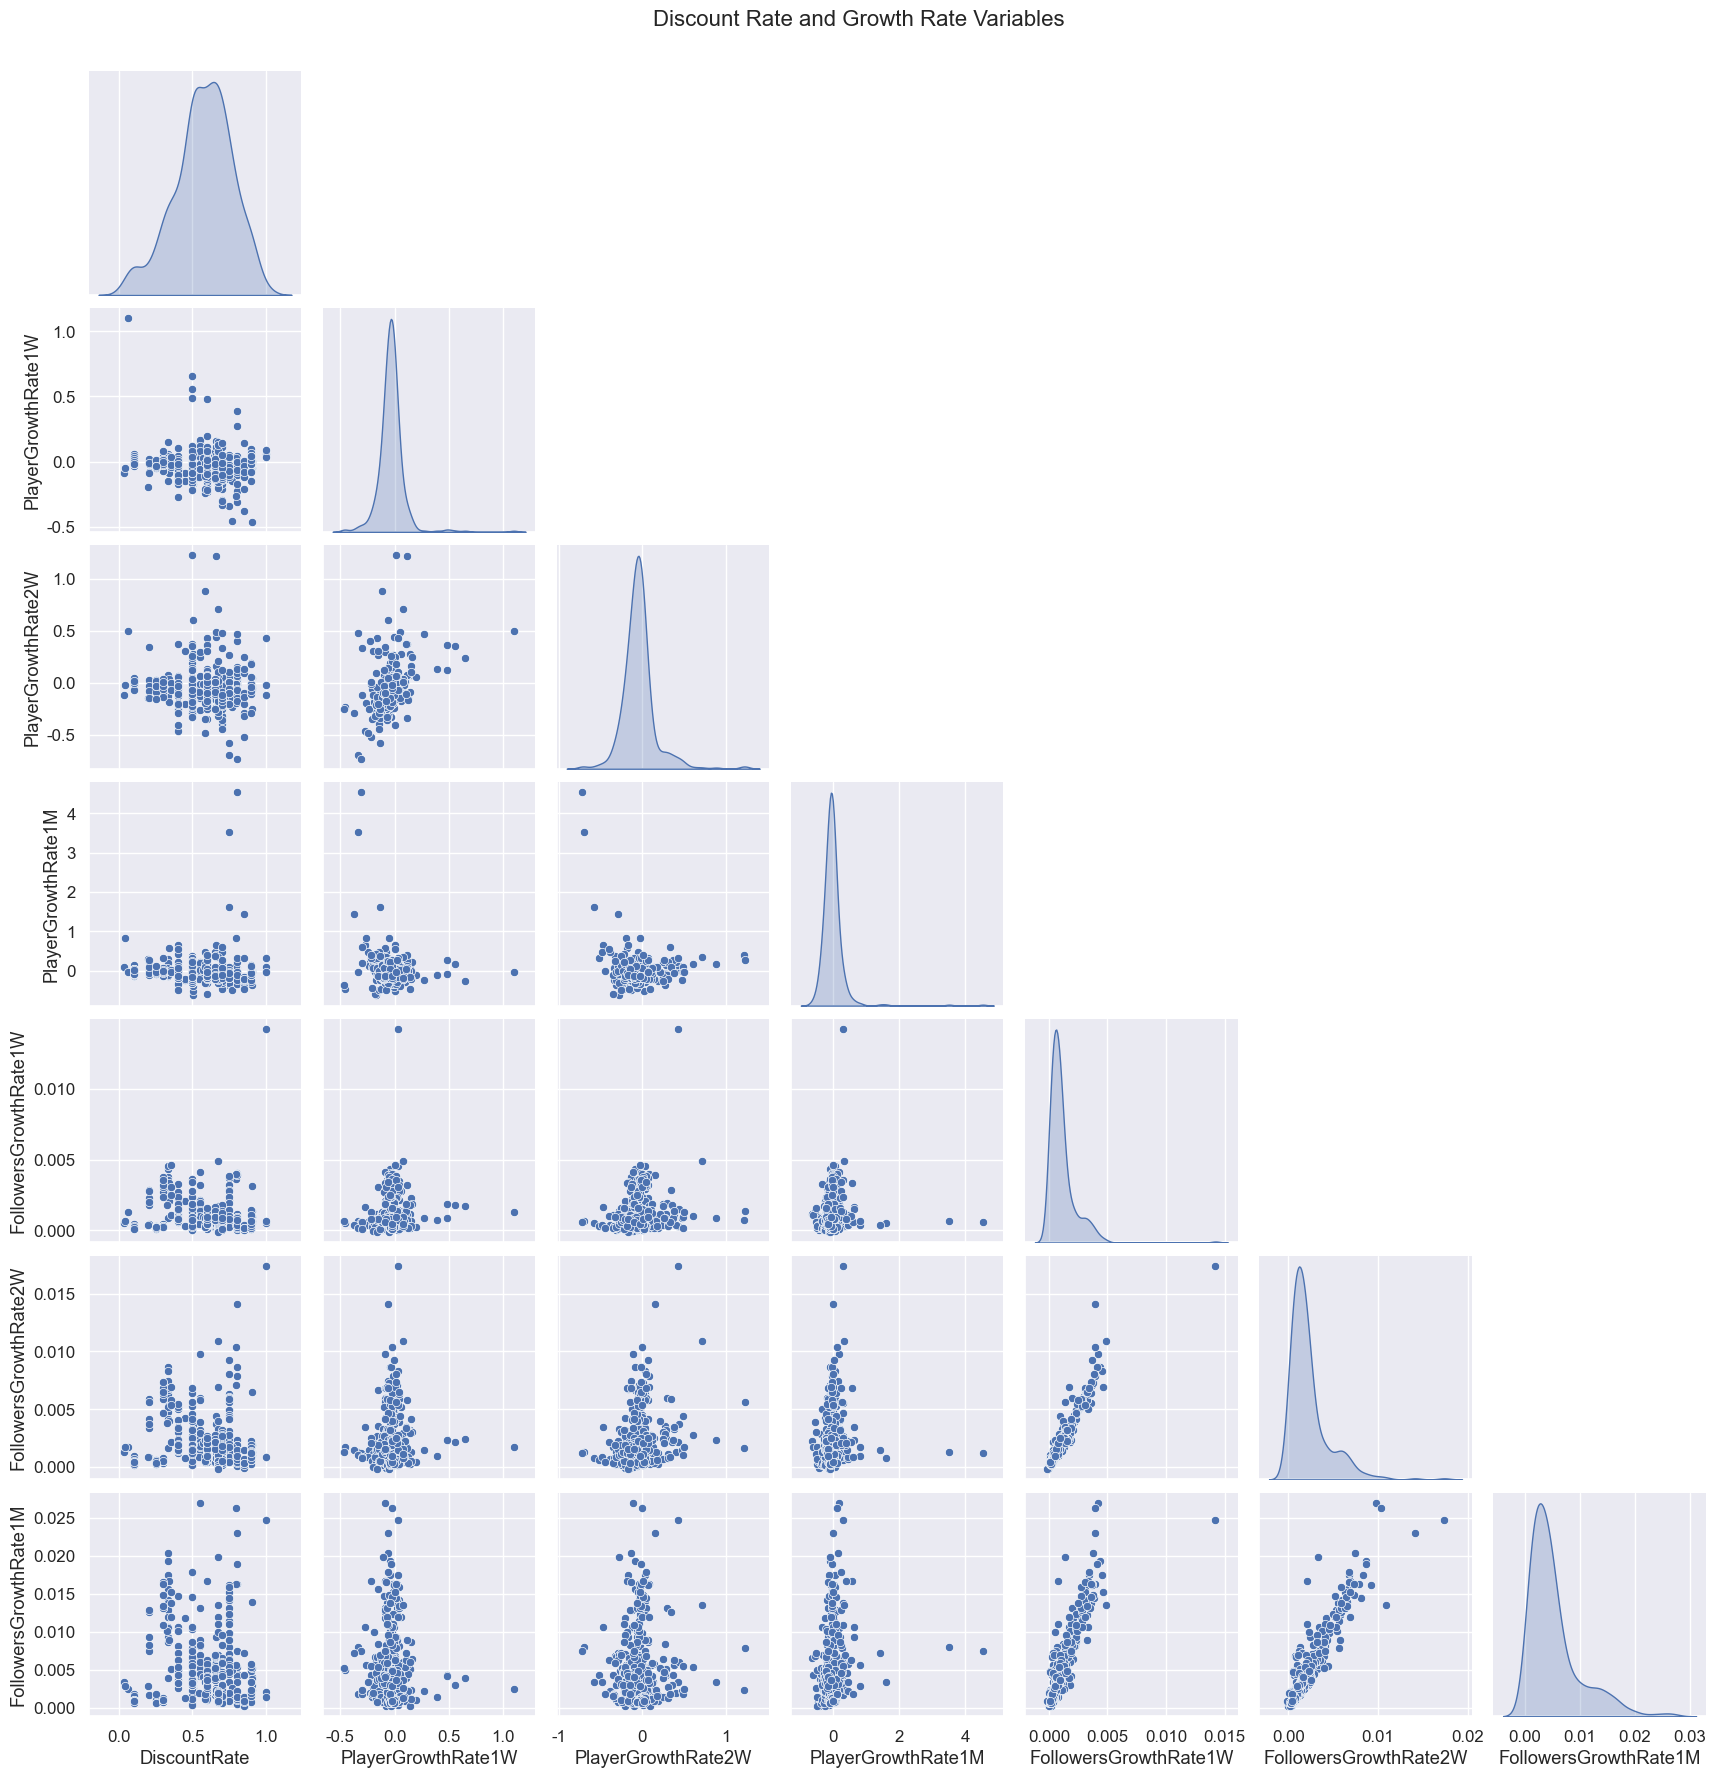

In [34]:
growth_cols = [
    "PlayerGrowthRate1W", "PlayerGrowthRate2W", "PlayerGrowthRate1M",
    "FollowersGrowthRate1W", "FollowersGrowthRate2W", "FollowersGrowthRate1M",
    "PositiveRateGrowthRate1W", "PositiveRateGrowthRate2W", "PositiveRateGrowthRate1M",
]

# 散佈圖矩陣
subset_cols = ["DiscountRate"] + growth_cols[:6]  # 取前幾個主要變數
sns.pairplot(df[subset_cols], diag_kind="kde", corner=True)
plt.suptitle("Discount Rate and Growth Rate Variables", y=1.02, fontsize=16)
plt.show()

1. 折扣幅度（DiscountRate）與成長率的關係  
- 散布圖顯示折扣率與各類成長率之間的相關性不明顯或偏弱。
- 數據分布相當分散，沒有明顯線性關係。

2. 各成長率變數之間的關聯性  
- 不同期間的成長率（例如 PlayerGrowthRate1W vs 2W, FollowersGrowthRate1W vs 2W）之間顯示出高度正相關。
  這表示成長趨勢具有連續性：若某遊戲在短期內成長迅速，後續幾週的成長速度也通常偏高。
  同時也表示在模型預測時，不應把同類型的成長率同時放入模型做預測。  

3. 分布特性  
- PlayerGrowthRate 各期間的分布偏右（右偏長尾），代表多數遊戲成長率低，只有少數熱門遊戲成長率非常高。  
- FollowersGrowthRate 的分布更為集中且值較小，顯示追隨者成長相對穩定。  


整體而言折扣率對成長率的直接影響有限，沒有明顯的正或負關聯。  
不同成長期間之間存在顯著正相關，成長具持續性。  
整體來看，折扣可能是輔助性的行銷因素，而非主要驅動遊戲成長的關鍵變數。

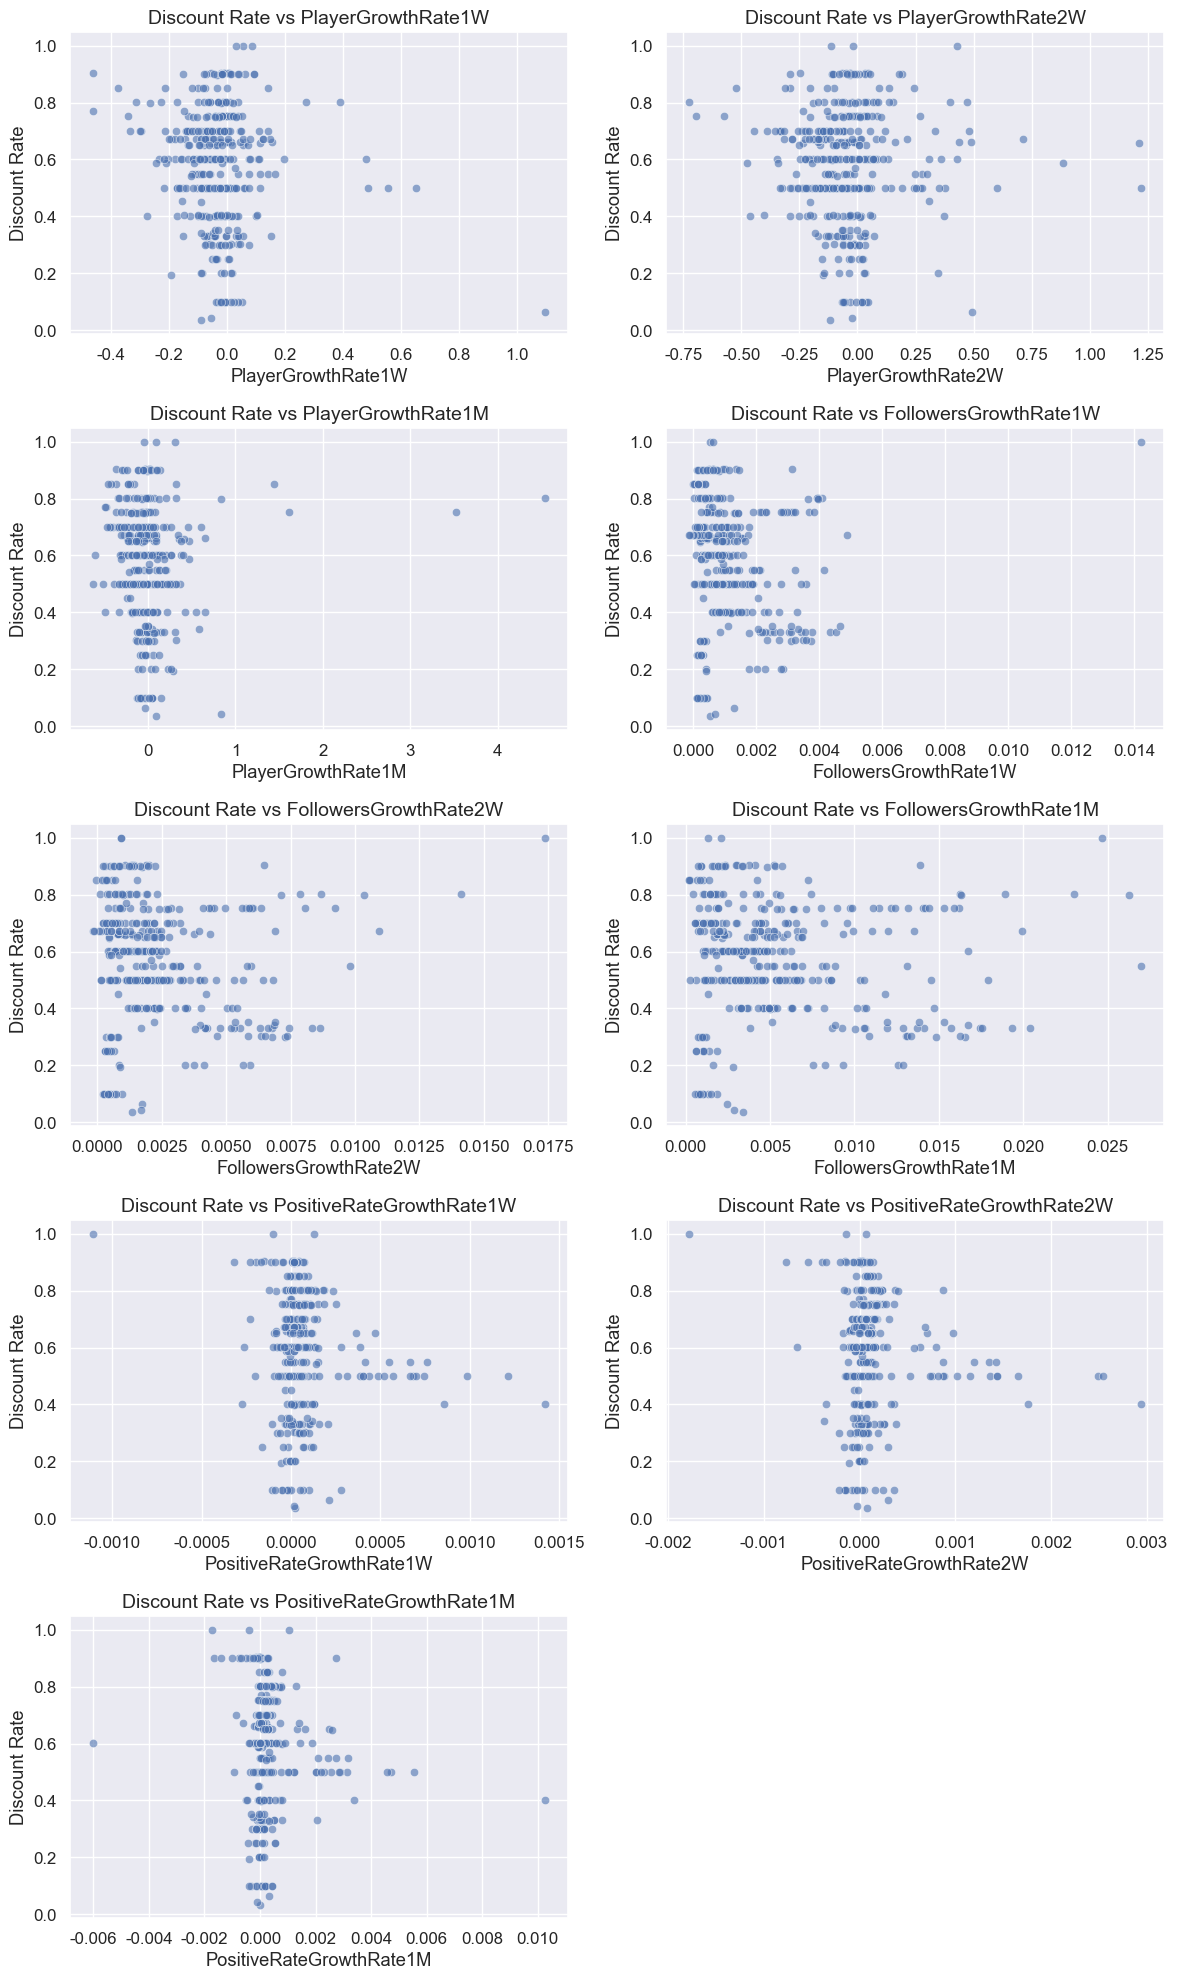

In [37]:
n = len(growth_cols)
rows = math.ceil(n / 2)

fig, axes = plt.subplots(rows, 2, figsize=(12, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(growth_cols):
    sns.scatterplot(data=df, x=col, y="DiscountRate", alpha=0.6, ax=axes[i])
    axes[i].set_title(f"Discount Rate vs {col}", fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Discount Rate")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


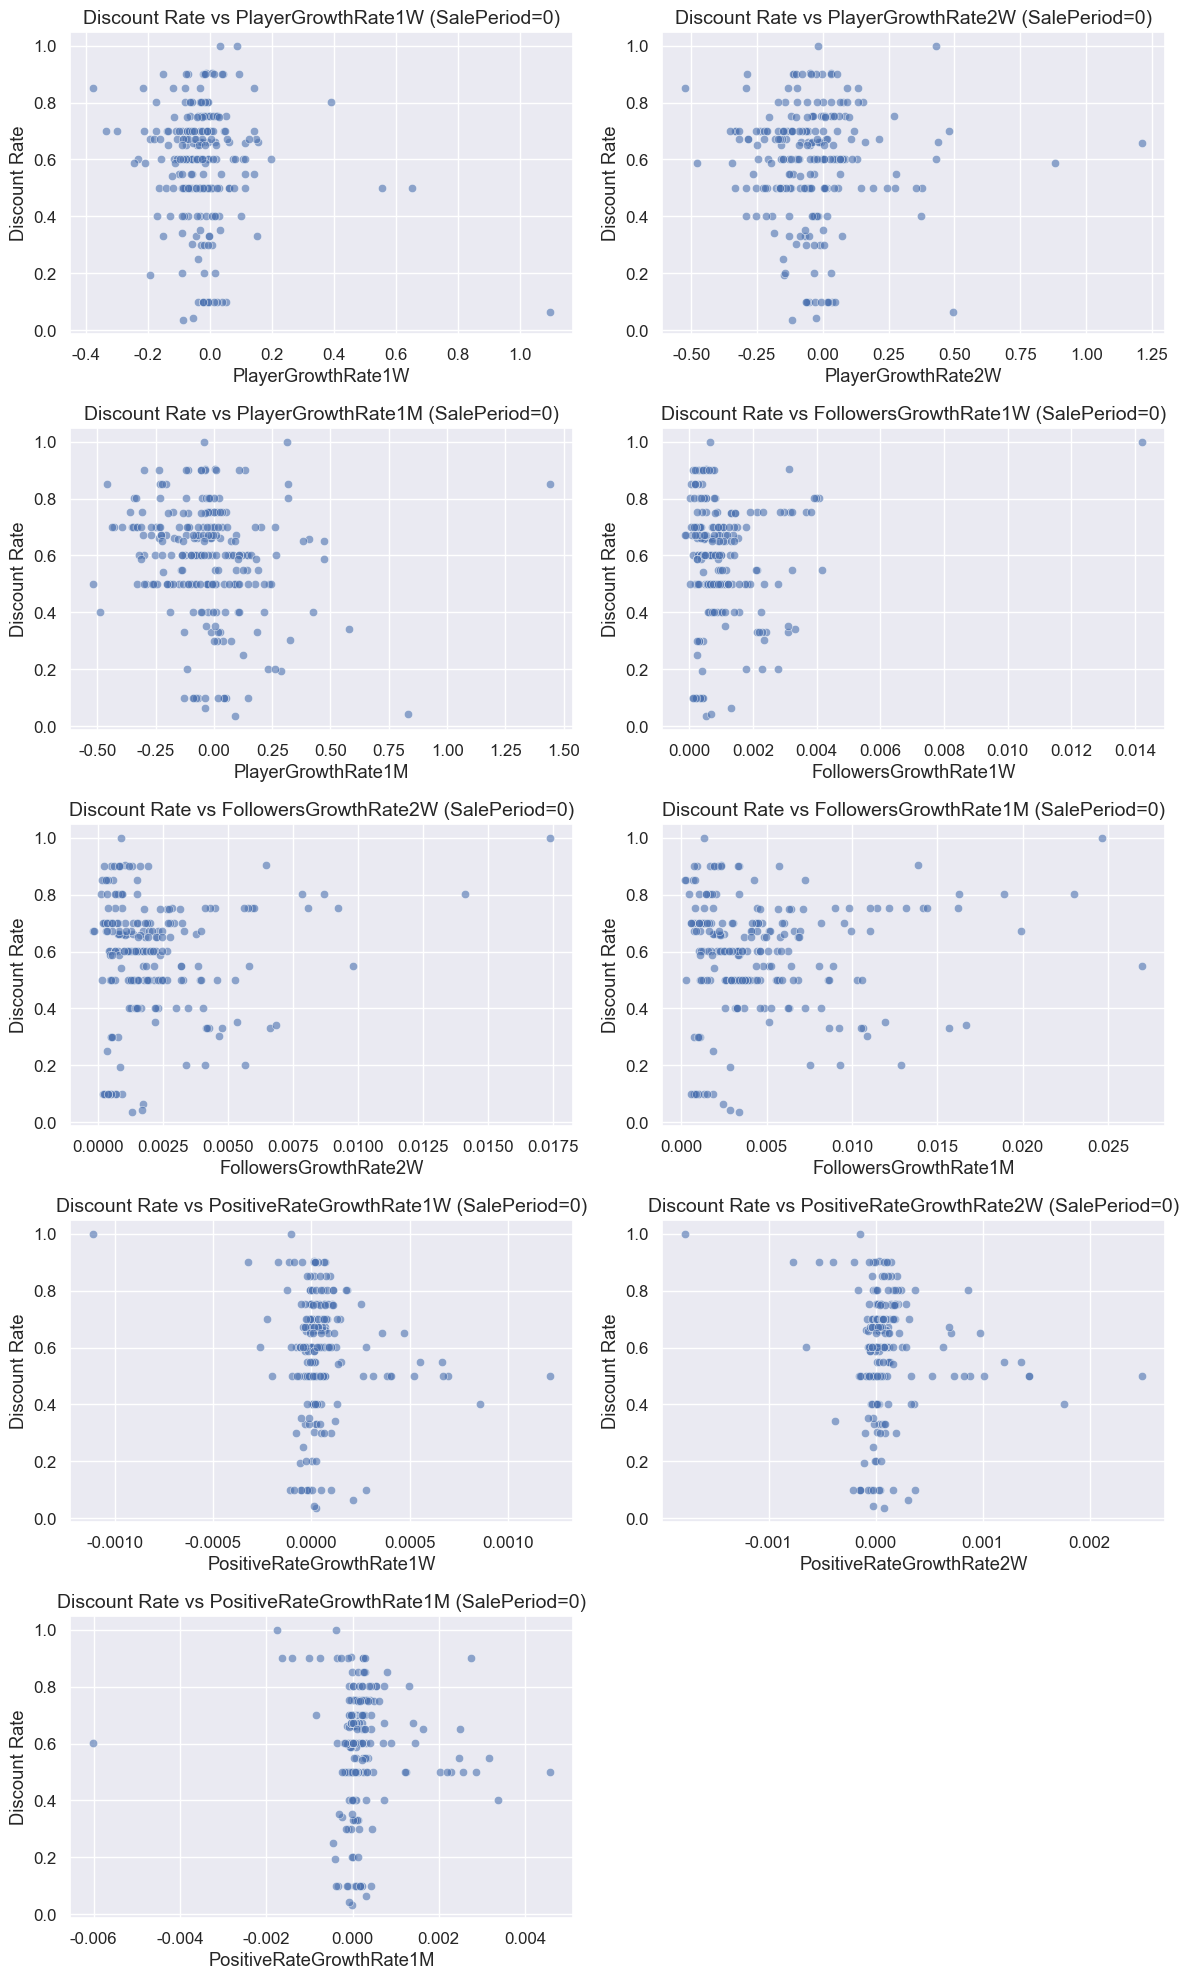

In [60]:
df_filtered = df[df["SalePeriod"] == 0]

n = len(growth_cols)
rows = math.ceil(n / 2)

fig, axes = plt.subplots(rows, 2, figsize=(12, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(growth_cols):
    sns.scatterplot(
        data=df_filtered,     # 使用過濾後的資料
        x=col,
        y="DiscountRate",
        alpha=0.6,
        ax=axes[i]
    )
    
    axes[i].set_title(f"Discount Rate vs {col} (SalePeriod=0)", fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Discount Rate")

# 刪除多餘空白子圖
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### D. 是否為季節性促銷期間 (SalesPeriod)對折扣率與其他變數的影響

從資料中隨機取50筆做 t-test ，分析促銷期間與非促銷期間的兩組樣本，是否存在顯著的差異性。

In [38]:
sample_df = df.sample(n=50, random_state=42)

# 變數清單
vars_to_test = [
    ("DiscountRate", "Discount Rate"),
    ("Age", "Game Age"),
    ("AccumulatedPositiveRate", "Positive Review Rate"),
    ("FollowersGrowthRate1W", "1-Week Follower Growth Rate"),
    ("PlayerGrowthRate1W", "1-Week Player Growth Rate")
]

results = []

for col, label in vars_to_test:
    group0 = sample_df[sample_df["SalePeriod"] == 0][col].dropna()
    group1 = sample_df[sample_df["SalePeriod"] == 1][col].dropna()
    
    n0, n1 = len(group0), len(group1)
    
    if n0 < 2 or n1 < 2:
        results.append({
            "Variable": label,
            "Non-seasonal Mean (SD)": "N/A",
            "Seasonal Mean (SD)": "N/A",
            "Mean Difference": "N/A",
            "p-value": "N/A",
            "n (Non-seasonal)": n0,
            "n (Seasonal)": n1
        })
        continue

    mean0, mean1 = group0.mean(), group1.mean()
    std0, std1 = group0.std(), group1.std()

    # t-test（不假設變異數相等）
    t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)

    results.append({
        "Variable": label,
        "Non-seasonal Mean (SD)": f"{mean0:.3f} ({std0:.3f})",
        "Seasonal Mean (SD)": f"{mean1:.3f} ({std1:.3f})",
        "Mean Difference": f"{(mean1 - mean0):.3f}",
        "p-value": f"{p_val:.4f}",
        "n (Non-seasonal)": n0,
        "n (Seasonal)": n1
    })


summary_df = pd.DataFrame(results)


title = "<h3>Table 1. Comparison Between Seasonal and Non-Seasonal Promotions (n=50)</h3>"
HTML(title + summary_df.to_html(index=False))

Variable,Non-seasonal Mean (SD),Seasonal Mean (SD),Mean Difference,p-value,n (Non-seasonal),n (Seasonal)
Discount Rate,0.566 (0.182),0.503 (0.174),-0.063,0.2179,27,23
Game Age,7.418 (4.502),6.928 (4.568),-0.490,0.7052,27,23
Positive Review Rate,0.926 (0.063),0.933 (0.057),0.008,0.6519,27,23
1-Week Follower Growth Rate,0.001 (0.001),0.001 (0.001),0.001,0.0179,27,23
1-Week Player Growth Rate,-0.034 (0.067),-0.040 (0.093),-0.006,0.7859,27,23


- 僅有1-Week Follower Growth Rate（追蹤者成長率）具有顯著差異(p = 0.0895 < 0.05)，季節促銷期間追蹤者成長率更高。  
- 季節促銷可能帶動社群關注度。即使折扣幅度不高，遊戲曝光與玩家互動仍顯著增加。

C:\Users\user\AppData\Local\Temp\ipykernel_12432\3017797436.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="SalePeriod", y="DiscountRate", palette=["#4C72B0", "#D55E00"])


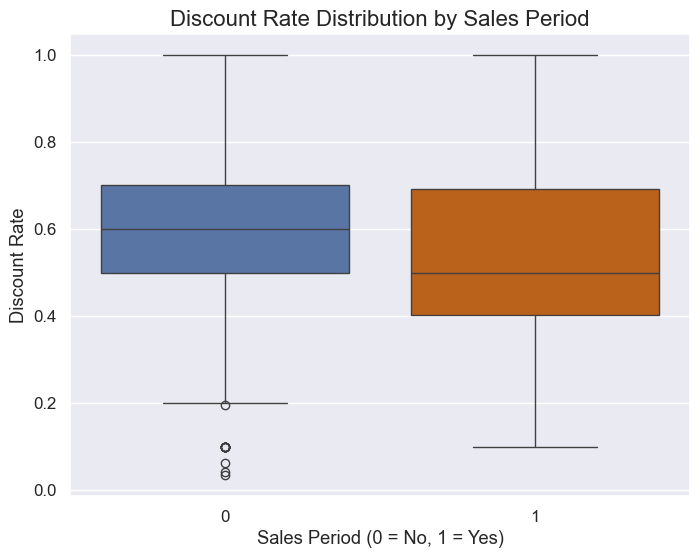

In [39]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="SalePeriod", y="DiscountRate", palette=["#4C72B0", "#D55E00"])
plt.title("Discount Rate Distribution by Sales Period", fontsize=16)
plt.xlabel("Sales Period (0 = No, 1 = Yes)")
plt.ylabel("Discount Rate")
plt.show()


- 可發現在非季節性促銷期間，遊戲廠商提供的折扣幅度更大(中位數0.6>0.5)。

C:\Users\user\AppData\Local\Temp\ipykernel_12432\790862086.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\user\AppData\Local\Temp\ipykernel_12432\790862086.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


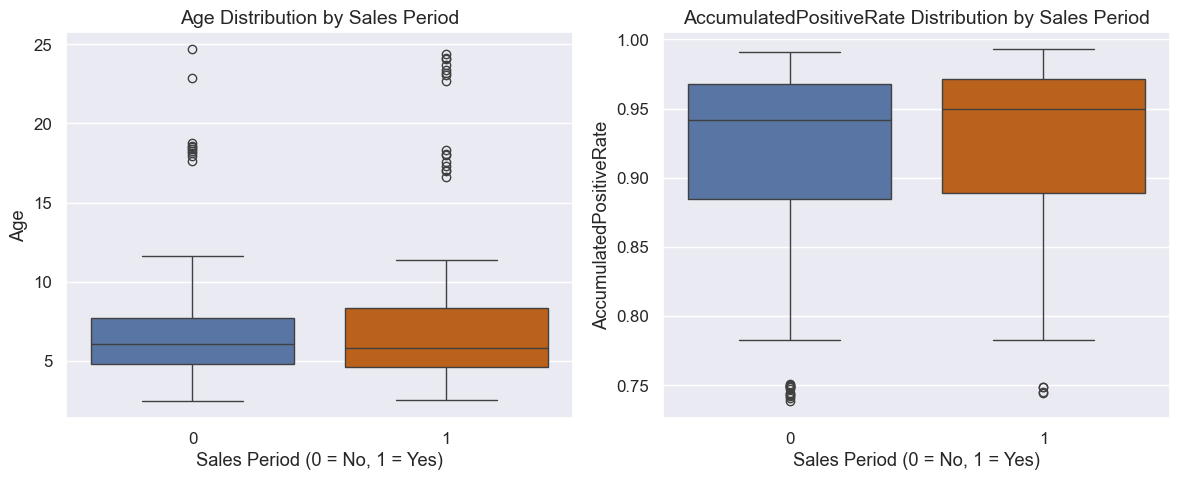

In [40]:
vars_to_compare = ["Age", "AccumulatedPositiveRate"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

# Age
sns.boxplot(
    data=df, x="SalePeriod", y=vars_to_compare[0],
    palette=["#4C72B0", "#D55E00"], ax=axes[0]
)
axes[0].set_title(f"{vars_to_compare[0]} Distribution by Sales Period", fontsize=14)
axes[0].set_xlabel("Sales Period (0 = No, 1 = Yes)")
axes[0].set_ylabel(vars_to_compare[0])

# AccumulatedPositiveRate
sns.boxplot(
    data=df, x="SalePeriod", y=vars_to_compare[1],
    palette=["#4C72B0", "#D55E00"], ax=axes[1]
)
axes[1].set_title(f"{vars_to_compare[1]} Distribution by Sales Period", fontsize=14)
axes[1].set_xlabel("Sales Period (0 = No, 1 = Yes)")
axes[1].set_ylabel(vars_to_compare[1])

plt.tight_layout()
plt.show()



促銷活動對不同發行時長的遊戲影響差異不大，但較老的遊戲仍可能略傾向於在促銷期間出現。  
促銷與否似乎不會顯著影響遊戲的整體評價分布；高評價遊戲在兩種情況下都佔主要比例。

### E. 是否為多人遊戲 (MultiPlayer)對折扣率與其他變數的影響

從資料中隨機取50筆做 t-test ，分析多人遊戲與非多人遊戲的兩組樣本，是否存在顯著的差異性。

In [42]:
sample_df = df.sample(n=50, random_state=42)

# 變數清單
vars_to_test = [
    ("DiscountRate", "Discount Rate"),
    ("Age", "Game Age"),
    ("AccumulatedPositiveRate", "Positive Review Rate"),
    ("FollowersGrowthRate1W", "1-Week Follower Growth Rate"),
    ("PlayerGrowthRate1W", "1-Week Player Growth Rate")
]

results = []

for col, label in vars_to_test:
    group0 = sample_df[sample_df["MultiPlayer"] == 0][col].dropna()
    group1 = sample_df[sample_df["MultiPlayer"] == 1][col].dropna()
    
    n0, n1 = len(group0), len(group1)
    
    if n0 < 2 or n1 < 2:
        results.append({
            "Variable": label,
            "Non-MultiPlayer Mean (SD)": "N/A",
            "MultiPlayer Mean (SD)": "N/A",
            "Mean Difference": "N/A",
            "p-value": "N/A",
            "n (Non-MultiPlayer)": n0,
            "n (MultiPlayer)": n1
        })
        continue

    mean0, mean1 = group0.mean(), group1.mean()
    std0, std1 = group0.std(), group1.std()

    # t-test（不假設變異數相等）
    t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)

    results.append({
        "Variable": label,
        "Non-MultiPlayer Mean (SD)": f"{mean0:.3f} ({std0:.3f})",
        "MultiPlayer Mean (SD)": f"{mean1:.3f} ({std1:.3f})",
        "Mean Difference": f"{(mean1 - mean0):.3f}",
        "p-value": f"{p_val:.4f}",
        "n (Non-MultiPlayer)": n0,
        "n (MultiPlayer)": n1
    })


summary_df = pd.DataFrame(results)


title = "<h3>Table 2. Comparison Between MultiPlayer and Non-MultiPlayer Promotions (n=50)</h3>"
HTML(title + summary_df.to_html(index=False))

Variable,Non-MultiPlayer Mean (SD),MultiPlayer Mean (SD),Mean Difference,p-value,n (Non-MultiPlayer),n (MultiPlayer)
Discount Rate,0.481 (0.152),0.608 (0.189),0.127,0.0145,28,22
Game Age,5.324 (1.498),9.571 (5.799),4.248,0.0028,28,22
Positive Review Rate,0.928 (0.059),0.931 (0.062),0.003,0.8487,28,22
1-Week Follower Growth Rate,0.001 (0.001),0.001 (0.001),-0.000,0.3823,28,22
1-Week Player Growth Rate,-0.033 (0.065),-0.042 (0.097),-0.010,0.6862,28,22


- 顯著差異出現在兩項：
     - 折扣幅度（Discount Rate）
     - 上市時間（Game Age）
多人遊戲傾向於「上市時間更久、折扣幅度更大」。

- 其他變數（好評率、成長率）差異不顯著：
     - 顯示促銷策略在短期內不會造成顯著的追蹤或玩家數成長差異。
     - 但長期而言，折扣策略可能仍有助於玩家回流或新玩家進入。

- 策略面解釋：
     - 多人遊戲為了維持伺服器活躍度，傾向透過更高折扣吸引玩家。
     - 非多人遊戲則可能依靠內容更新或評價口碑維持銷量，不一定需要大幅折扣

C:\Users\user\AppData\Local\Temp\ipykernel_12432\4250661804.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="MultiPlayer", y="DiscountRate", palette=["#4C72B0", "#D55E00"])


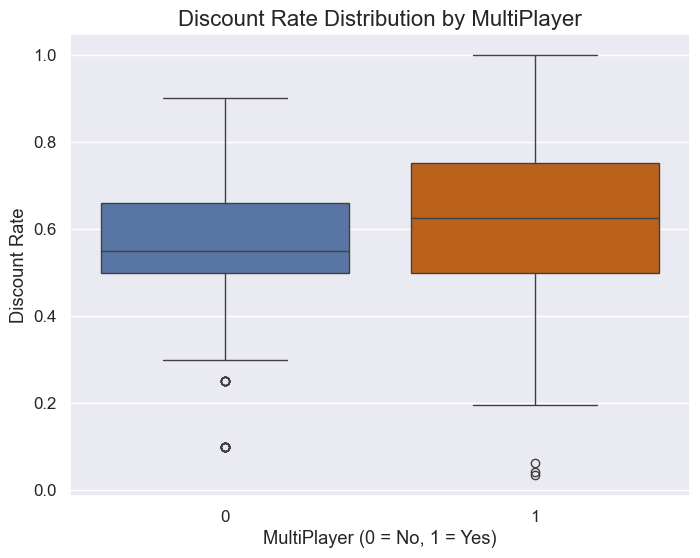

In [43]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="MultiPlayer", y="DiscountRate", palette=["#4C72B0", "#D55E00"])
plt.title("Discount Rate Distribution by MultiPlayer", fontsize=16)
plt.xlabel("MultiPlayer (0 = No, 1 = Yes)")
plt.ylabel("Discount Rate")
plt.show()

- 多人遊戲略有更高折扣幅度的傾向。

C:\Users\user\AppData\Local\Temp\ipykernel_12432\367623257.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\user\AppData\Local\Temp\ipykernel_12432\367623257.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


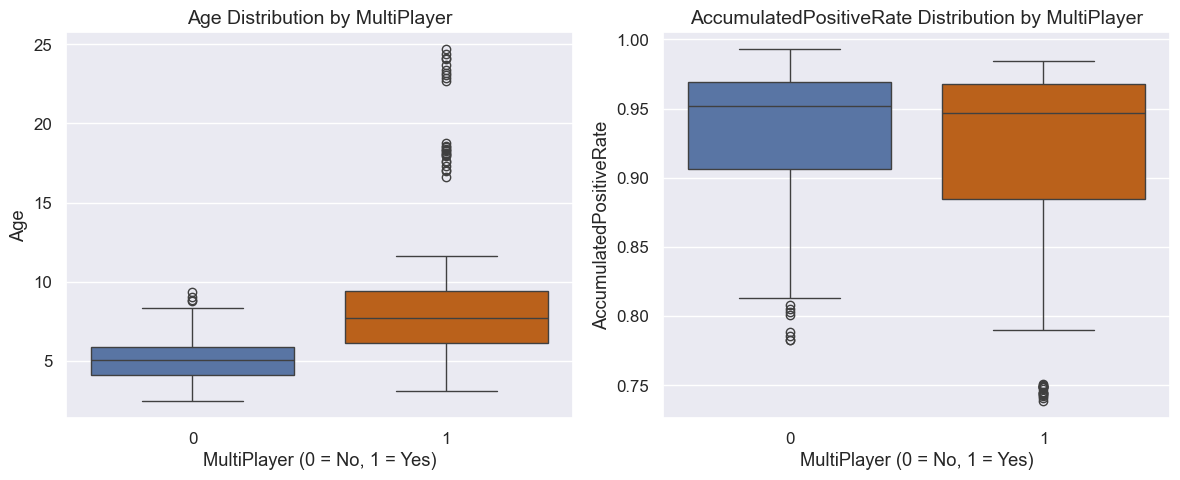

In [44]:
vars_to_compare = ["Age", "AccumulatedPositiveRate"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

# Age
sns.boxplot(
    data=df, x="MultiPlayer", y=vars_to_compare[0],
    palette=["#4C72B0", "#D55E00"], ax=axes[0]
)
axes[0].set_title(f"{vars_to_compare[0]} Distribution by MultiPlayer", fontsize=14)
axes[0].set_xlabel("MultiPlayer (0 = No, 1 = Yes)")
axes[0].set_ylabel(vars_to_compare[0])

# AccumulatedPositiveRate
sns.boxplot(
    data=df, x="MultiPlayer", y=vars_to_compare[1],
    palette=["#4C72B0", "#D55E00"], ax=axes[1]
)
axes[1].set_title(f"{vars_to_compare[1]} Distribution by MultiPlayer", fontsize=14)
axes[1].set_xlabel("MultiPlayer (0 = No, 1 = Yes)")
axes[1].set_ylabel(vars_to_compare[1])

plt.tight_layout()
plt.show()

- 發現多人遊戲較分多人遊戲發行時間較久。


### E. 整體相關性

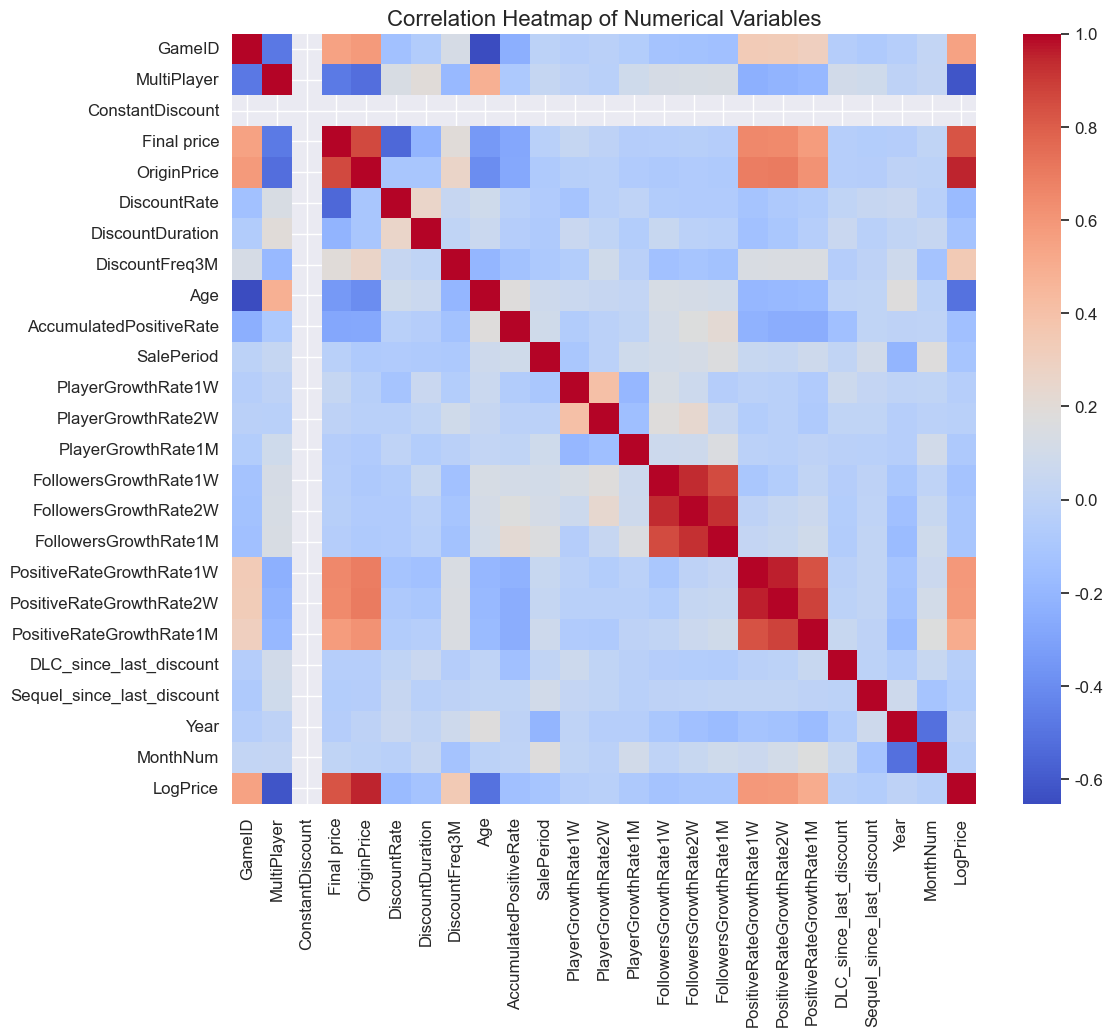

與 DiscountRate 最相關的變數前 8 名：


DiscountDuration              0.258958
MultiPlayer                   0.141019
Age                           0.089769
Year                          0.051439
DiscountFreq3M                0.044425
Sequel_since_last_discount    0.042201
DLC_since_last_discount       0.007914
PlayerGrowthRate1M            0.002370
Name: DiscountRate, dtype: float64

In [45]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Numerical Variables", fontsize=16)
plt.show()

# 顯示與 DiscountRate 相關最高的前 8 名
top_corr = corr["DiscountRate"].drop("DiscountRate").sort_values(ascending=False)
print("與 DiscountRate 最相關的變數前 8 名：")
display(top_corr.head(8))